# TEXT ONLY hate speech detection (without consider emojis)

In [62]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from matplotlib import backends
import matplotlib.pyplot as plt
import seaborn
import warnings
warnings.filterwarnings("ignore")
import nltk

In [63]:
df = pd.read_csv("labeled_data.csv")

In [64]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [65]:
df["tweet"].head()

0    !!! RT @mayasolovely: As a woman you shouldn't...
1    !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2    !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3    !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4    !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
Name: tweet, dtype: object

In [66]:
df["class"].head()

0    2
1    1
2    1
3    1
4    1
Name: class, dtype: int64

In [67]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [68]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

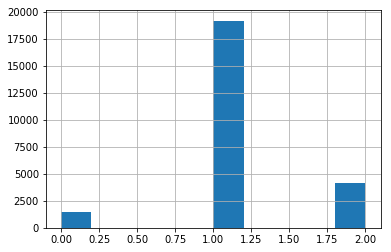

In [69]:
df["class"].hist()
plt.show()

In [70]:
tweets=df.tweet

In [11]:
hateDict = pd.read_csv('hatebase_dict.csv', header = None)
hateDict.columns = ['hateWord']
hateDict.head()

,hateWord
0,"uncivilised',"
1,"'gypo',"
2,"'gypos',"
3,"'cunt',"
4,"'cunts',"


# 1. text pre process

## stop words without negative meaning

In [12]:
stopwords = nltk.corpus.stopwords.words("english")

In [13]:
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

In [14]:
negativeNotion = ['but','no','nor','not',"don't",'ain','aren',"aren't",'couldn',"couldn't",
                  'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",
                  'isn',"isn't",'mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'shan',"shan't", 
                  'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't"]

In [15]:
for i in negativeNotion:
    if(i in stopwords):
        stopwords.remove(i)

## constraction

In [16]:
contractions = { "ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have",
                "cause": "because", "could've": "could have","couldn't": "could not","couldn't've": 
                "could not have","didn't": "did not", "doesn't": "does not","don't": "do not","hadn't": "had not",
                "hadn't've": "had not have","hasn't": "has not","haven't": "have not","he'd": "he had",
                "he'd've": "he would have","he'll": "he shall","he'll've": "he shall have","he's": "he has",
                "how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how has",
                "i'd": "I had","i'd've": "I would have","i'll": "I shall","i'll've": "I shall have",
                "i'm": "I am","i've": "I have","isn't": "is not","it'd": "it had","it'd've": "it would have",
                "it'll": "it shall","it'll've": "it shall have","it's": "it has","let's": "let us","ma'am": "madam",
                "mayn't": "may not","might've": "might have","mightn't": "might not","mightn't've": "might not have",
                "must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have",
                "o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have",
                "shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have","she'd": "she had","she'd've": "she would have",
                "she'll": "she shall","she'll've": "she shall have","she's": "she has","should've": "should have","shouldn't": "should not",
                "shouldn't've": "should not have","so've": "so have","so's": "so as","that'd": "that would",
                "that'd've": "that would have","that's": "that has","there'd": "there had","there'd've": "there would have","there's": "there has",
                "they'd": "they had", "they'd've": "they would have", "they'll": "they shall",
                "they'll've": "they shall have","they're": "they are","they've": "they have","to've": "to have",
                "wasn't": "was not","we'd": "we had","we'd've": "we would have","we'll": "we will", "we'll've": "we will have",
                "we're": "we are","we've": "we have","weren't": "were not","what'll": "what shall",
                "what'll've": "what shall have","what're": "what are","what's": "what has","what've": "what have",
                "when's": "when has","when've": "when have","where'd": "where did","where's": "where has",
                "where've": "where have","who'll": "who shall","who'll've": "who shall have","who's": "who has",
                "who've": "who have","why's": "why has","why've": "why have","will've": "will have",
                "won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not","wouldn't've": "would not have",
                "y'all": "you all","y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
                "y'all've": "you all have","you'd": "you had","you'd've": "you would have","you'll": "you shall",
                "you'll've": "you shall have","you're": "you are","you've": "you have","that's": "that is",
                "ya": "you","im": "I am"}

In [17]:
stemmer = PorterStemmer()

In [18]:
def preprocess(text_string):
    space_pattern='\s+'
    giant_url_regex=('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern,' ',text_string)
    parsed_text = re.sub(giant_url_regex,'',parsed_text)
    parsed_text = re.sub(mention_regex,'',parsed_text)
    
    return parsed_text

In [20]:
def tokenize(tweet):
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

In [21]:
def basic_tokenize(tweet):
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

# 2. tfidf
## 2.1 tfidf using stemming

In [20]:
#tfidf using tokenizing with stem
vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1,4),
    #stop_words=stopwords,
    use_idf=True,
    smooth_idf=True,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [22]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

## 2.2 process using lemmatizing

In [23]:
# tokenize and lemmetize
from textblob import TextBlob
from textblob import Word

def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

def tokenize_lemmetize(tweet):
#     tweet = TextBlob(tweet.lower())
    tokens = lemmatize_with_postag(tweet.lower())
    return tokens

In [24]:
# tfidf using tokenizing with lemmatize
vectorizer_lem = TfidfVectorizer(
    tokenizer=tokenize_lemmetize,
    preprocessor=preprocess,
    ngram_range=(1,4),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=True,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [25]:
#Construct tfidf_lem matrix and get relevant scores
tfidf_lem = vectorizer_lem.fit_transform(tweets).toarray()
vocab_lem = {v:i for i, v in enumerate(vectorizer_lem.get_feature_names())}
idf_vals_lem = vectorizer_lem.idf_
idf_dict_lem = {i:idf_vals_lem[i] for i in vocab_lem.values()} #keys are indices; values are IDF scores

## 2.3 pos tag tfidf

In [26]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets: 
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags] 
    tag_str = " ".join(tag_list) 
    tweet_tags.append(tag_str)

In [27]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1,4),
    stop_words=None,
    use_idf=False,
    smooth_idf=True,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [28]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [29]:
#Now get other features
sentiment_analyzer = VS()

In [30]:
#parse text, count twitter object 
def count_twitter_objs(text_string):
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

In [31]:
def other_features(tweet):
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    words = preprocess(tweet)

    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    num_hateful_words = 0
    for word in hateDict:
        if word in words:
            num_hateful_words += 1

    #Flesch-Kincaid grade level: measure readability of text
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    #Flesch readability ease: measure readability of text
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    #是否转发？
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, num_hateful_words, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],twitter_objs[0], retweet]
    return features

In [32]:
def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [33]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "num_hateful_words","vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [34]:
feats = get_feature_array(tweets)

In [35]:
feats

array([[  8.3 ,  79.94,  30.  , ...,   1.  ,   0.  ,   0.  ],
       [  4.7 ,  90.13,  19.  , ...,   1.  ,   0.  ,   0.  ],
       [  5.8 ,  89.25,  23.  , ...,   2.  ,   0.  ,   1.  ],
       ...,
       [  3.1 ,  96.03,  15.  , ...,   0.  ,   0.  ,   0.  ],
       [  0.6 , 103.05,   8.  , ...,   0.  ,   0.  ,   0.  ],
       [  9.8 ,  55.22,  27.  , ...,   0.  ,   1.  ,   0.  ]])

In [36]:
#Now join all up
M_tfidf = np.concatenate([tfidf,pos,feats],axis=1)

In [37]:
M_tfidf.shape

(24783, 15018)

In [36]:
M_lem = np.concatenate([tfidf_lem,pos,feats],axis=1)
M_lem.shape

(24783, 15018)

In [40]:
#Finally get a list of variable names
variables = ['']*len(vocab_lem)
for k,v in vocab_lem.items():
    variables[v] = k

# variables = ['']*len(vocab)
# for k,v in vocab.items():
#     variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables + pos_variables + other_features_names

In [41]:
len(feature_names) # stemming result

15018

In [42]:
len(feature_names) # lemmatizing result

15018

# 3. Running models

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.svm import SVC

In [44]:
X = pd.DataFrame(M_tfidf)
y = df['class'].astype(int)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [46]:
X = pd.DataFrame(M_lem)
y = df['class'].astype(int)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, random_state=42, test_size=0.25)

In [47]:
from sklearn.model_selection import cross_val_predict
def train_model(model):
    # feature selection
    select = SelectFromModel(model)
    select.fit(X_train, y_train)
    X_new = select.transform(X_train)
    X_test_new = select.transform(X_test)

    # cross validation 
    gs = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5, random_state=33).split(X_new, y_train), verbose=2)
    gs_model = gs.fit(X_new, y_train)
    y_pred = gs_model.predict(X_test_new)
    report = classification_report(y_pred, y_test)
    print(report)
    return 

In [48]:
def train_model(model):
    # feature selection
    select = SelectFromModel(model)
    select.fit(X_train1, y_train1)
    X_new = select.transform(X_train1)
    X_test_new = select.transform(X_test1)

    # cross validation 
    gs = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5, random_state=33).split(X_new, y_train1), verbose=2)
    gs_model = gs.fit(X_new, y_train1)
    y_pred = gs_model.predict(X_test_new)
    report = classification_report(y_pred, y_test1)
    print(report)
    return 

# 3.1 Results using stemming

### 1. LinearSVC

In [76]:
LSVC = LinearSVC(penalty="l2",C=0.01,multi_class='ovr')
train_model(LSVC)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ................................................. , total=   6.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV] ................................................. , total=   6.7s
[CV]  ................................................................
[CV] ................................................. , total=   6.4s
[CV]  ................................................................
[CV] ................................................. , total=   6.4s
[CV]  ................................................................
[CV] ................................................. , total=   6.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.8s finished


             precision    recall  f1-score   support

          0       0.33      0.39      0.36       303
          1       0.93      0.92      0.93      4832
          2       0.82      0.80      0.81      1061

avg / total       0.88      0.88      0.88      6196



### 2. Random Forest Classifier

In [77]:
RF = RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0)
train_model(RF)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ................................................. , total=  12.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.9s remaining:    0.0s


[CV] ................................................. , total=  12.6s
[CV]  ................................................................
[CV] ................................................. , total=  12.5s
[CV]  ................................................................
[CV] ................................................. , total=  12.9s
[CV]  ................................................................
[CV] ................................................. , total=  12.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


             precision    recall  f1-score   support

          0       0.01      0.50      0.03        10
          1       0.99      0.84      0.91      5649
          2       0.46      0.89      0.61       537

avg / total       0.94      0.84      0.88      6196



### 3. Decision Tree

In [78]:
DT = tree.DecisionTreeClassifier()
train_model(DT)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ................................................. , total=   8.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.0s remaining:    0.0s


[CV] ................................................. , total=   8.8s
[CV]  ................................................................
[CV] ................................................. , total=   8.7s
[CV]  ................................................................
[CV] ................................................. , total=   8.2s
[CV]  ................................................................
[CV] ................................................. , total=   9.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.4s finished


             precision    recall  f1-score   support

          0       0.30      0.32      0.31       333
          1       0.93      0.93      0.93      4803
          2       0.83      0.82      0.83      1060

avg / total       0.88      0.87      0.88      6196



### 4. Logistic Regression + L2

In [79]:
LR_l2 = LogisticRegression(class_weight='balanced',penalty="l2", C=0.01)
train_model(LR_l2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ................................................. , total=   6.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] ................................................. , total=   5.6s
[CV]  ................................................................
[CV] ................................................. , total=   5.5s
[CV]  ................................................................
[CV] ................................................. , total=   5.5s
[CV]  ................................................................
[CV] ................................................. , total=   5.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   29.3s finished


             precision    recall  f1-score   support

          0       0.45      0.41      0.43       389
          1       0.92      0.95      0.93      4641
          2       0.90      0.81      0.85      1166

avg / total       0.89      0.89      0.89      6196



### 5. Logistic Regression + L1

In [80]:
LR_l1 = LogisticRegression(class_weight='balanced',penalty="l1", C=0.01)
train_model(LR_l1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ................................................. , total=   0.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ................................................. , total=   1.2s
[CV]  ................................................................
[CV] ................................................. , total=   1.0s
[CV]  ................................................................
[CV] ................................................. , total=   1.0s
[CV]  ................................................................
[CV] ................................................. , total=   1.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.1s finished


             precision    recall  f1-score   support

          0       0.52      0.40      0.45       461
          1       0.89      0.97      0.93      4408
          2       0.96      0.75      0.84      1327

avg / total       0.88      0.88      0.87      6196



In [67]:
#用gridsearch train model
pipe = Pipeline(
        [('lr2', SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l2", C=0.01))),
         ('lsvc', SelectFromModel(LinearSVC(penalty="l2",C=0.01,multi_class='ovr'))),
#          ('RF',SelectFromModel(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0))),
         ('DT',SelectFromModel(tree.DecisionTreeClassifier())),
        ('model', LogisticRegression(class_weight='balanced',penalty='l1',C=0.01))])

In [68]:
param_grid = [{}] # Optionally add parameters here
grid_search = GridSearchCV(pipe, 
                           param_grid, 
                           cv=StratifiedKFold(n_splits=10, random_state=33).split(X_train, y_train), 
                           verbose=2)

In [69]:
model = grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV] ................................................. , total=  24.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.9s remaining:    0.0s


[CV] ................................................. , total=  17.5s
[CV]  ................................................................
[CV] ................................................. , total=  18.9s
[CV]  ................................................................
[CV] ................................................. , total=  17.7s
[CV]  ................................................................
[CV] ................................................. , total=  18.4s
[CV]  ................................................................
[CV] ................................................. , total=  18.5s
[CV]  ................................................................
[CV] ................................................. , total=  18.4s
[CV]  ................................................................
[CV] ................................................. , total=  20.4s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.7min finished


In [81]:
y_preds = model.predict(X_test)

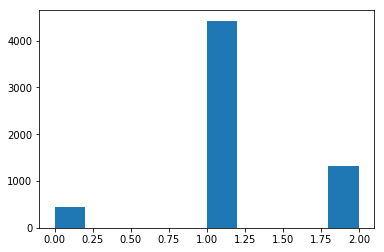

In [82]:
plt.hist(y_preds)
plt.show()

In [84]:
report = classification_report(y_preds,y_test)
print(report)

             precision    recall  f1-score   support

          0       0.50      0.41      0.45       443
          1       0.89      0.97      0.93      4428
          2       0.96      0.75      0.84      1325

avg / total       0.88      0.88      0.88      6196



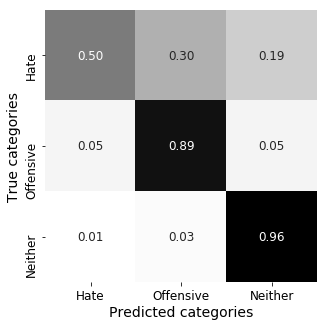

In [86]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

# 3.2 Results using lemmatizing

### 1. LinearSVC

In [50]:
param_grid = [{}]
LSVC = LinearSVC(penalty="l2",C=0.01,multi_class='ovr')
train_model(LSVC)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ................................................. , total=  11.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.7s remaining:    0.0s


[CV] ................................................. , total=  10.0s
[CV]  ................................................................
[CV] ................................................. , total=   9.3s
[CV]  ................................................................
[CV] ................................................. , total=   9.6s
[CV]  ................................................................
[CV] ................................................. , total=   9.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.9s finished


             precision    recall  f1-score   support

          0       0.27      0.29      0.28       336
          1       0.91      0.90      0.90      4862
          2       0.69      0.72      0.71       998

avg / total       0.84      0.84      0.84      6196



### 2. Random Forest Classifier

In [51]:
RF = RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0)
train_model(RF)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ................................................. , total=  13.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.3s remaining:    0.0s


[CV] ................................................. , total=  14.0s
[CV]  ................................................................
[CV] ................................................. , total=  13.7s
[CV]  ................................................................
[CV] ................................................. , total=  13.8s
[CV]  ................................................................
[CV] ................................................. , total=  14.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished


             precision    recall  f1-score   support

          0       0.02      0.44      0.04        16
          1       0.98      0.86      0.92      5445
          2       0.60      0.85      0.70       735

avg / total       0.93      0.86      0.89      6196



### 3. Decision Tree

In [52]:
DT = tree.DecisionTreeClassifier()
train_model(DT)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ................................................. , total=  11.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


[CV] ................................................. , total=  11.3s
[CV]  ................................................................
[CV] ................................................. , total=  11.2s
[CV]  ................................................................
[CV] ................................................. , total=  10.6s
[CV]  ................................................................
[CV] ................................................. , total=  12.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   57.2s finished


             precision    recall  f1-score   support

          0       0.19      0.22      0.20       311
          1       0.89      0.88      0.89      4842
          2       0.66      0.66      0.66      1043

avg / total       0.82      0.81      0.81      6196



### 4. Logistic Regression + L2

In [53]:
LR_l2 = LogisticRegression(class_weight='balanced',penalty="l2", C=0.01)
train_model(LR_l2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ................................................. , total=   8.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[CV] ................................................. , total=   7.6s
[CV]  ................................................................
[CV] ................................................. , total=   7.6s
[CV]  ................................................................
[CV] ................................................. , total=   7.4s
[CV]  ................................................................
[CV] ................................................. , total=   8.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   40.1s finished


             precision    recall  f1-score   support

          0       0.38      0.37      0.37       374
          1       0.91      0.92      0.91      4721
          2       0.78      0.74      0.76      1101

avg / total       0.85      0.85      0.85      6196



### 5. Logistic Regression + L1

In [54]:
LR_l1 = LogisticRegression(class_weight='balanced',penalty="l1", C=0.01)
train_model(LR_l1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ................................................. , total=   2.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV] ................................................. , total=   2.1s
[CV]  ................................................................
[CV] ................................................. , total=   2.7s
[CV]  ................................................................
[CV] ................................................. , total=   2.9s
[CV]  ................................................................
[CV] ................................................. , total=   2.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.8s finished


             precision    recall  f1-score   support

          0       0.46      0.40      0.43       413
          1       0.89      0.94      0.91      4517
          2       0.85      0.70      0.76      1266

avg / total       0.85      0.85      0.85      6196



In [55]:
pipe = Pipeline(
        [('lr2', SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l2", C=0.01))),
         ('lsvc', SelectFromModel(LinearSVC(penalty="l2",C=0.01,multi_class='ovr'))),
#          ('RF',SelectFromModel(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0))),
#          ('DT',SelectFromModel(tree.DecisionTreeClassifier())),
        ('model', LogisticRegression(class_weight='balanced',penalty='l1',C=0.01))])

grid_search = GridSearchCV(pipe, 
                           param_grid, 
                           cv=StratifiedKFold(n_splits=10, random_state=33).split(X_train1, y_train1), 
                           verbose=2)
model = grid_search.fit(X_train1, y_train1)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV] ................................................. , total=  23.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.4s remaining:    0.0s


[CV] ................................................. , total=  21.6s
[CV]  ................................................................
[CV] ................................................. , total=  21.6s
[CV]  ................................................................
[CV] ................................................. , total=  19.5s
[CV]  ................................................................
[CV] ................................................. , total=  20.5s
[CV]  ................................................................
[CV] ................................................. , total=  21.7s
[CV]  ................................................................
[CV] ................................................. , total=  21.1s
[CV]  ................................................................
[CV] ................................................. , total=  21.2s
[CV]  ................................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  4.1min finished


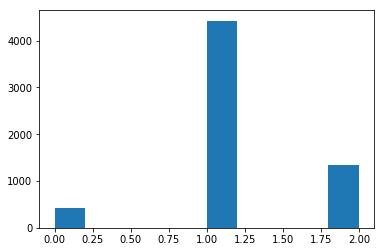

In [56]:
y_preds = model.predict(X_test1)
plt.hist(y_preds)
plt.show()

In [58]:
report = classification_report(y_preds,y_test1)
print(report)

             precision    recall  f1-score   support

          0       0.46      0.40      0.42       416
          1       0.87      0.94      0.91      4428
          2       0.86      0.67      0.75      1352

avg / total       0.84      0.85      0.84      6196



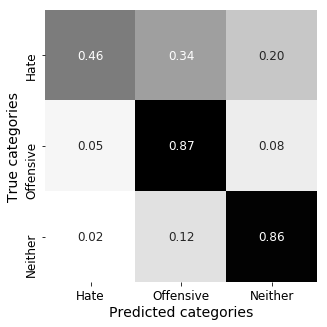

In [61]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test1,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)